# Capture fraction example

From:
Bakker, Mark, Post, Vincent, Langevin, C. D., Hughes, J. D., White, J. T., Starn, J. J. and Fienen, M. N., 2016, Scripting MODFLOW Model Development Using Python and FloPy: Groundwater, v. 54, p. 733-739, https://doi.org/10.1111/gwat.12413.

In [1]:
import os
import sys
from pathlib import Path
from pprint import pformat

import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
import scipy.ndimage

import flopy

print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.12.10 | packaged by conda-forge | (main, Apr 10 2025, 22:21:13) [GCC 13.3.0]
numpy version: 2.2.5
matplotlib version: 3.10.3
flopy version: 3.9.3


In [2]:
ws = os.path.join("temp")
if not os.path.exists(ws):
    os.makedirs(ws)

Check if we are in the repository and define the data path.

In [3]:
try:
    root = Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None

In [4]:
data_path = root / ".docs" / "groundwater_paper" if root else Path.cwd()

In [5]:
fname = "USPB_capture_fraction_04_01.dat"
pooch.retrieve(
    url=f"https://github.com/modflowpy/flopy/raw/develop/.docs/groundwater_paper/uspb/results/{fname}",
    fname=fname,
    path=data_path / "uspb" / "results",
    known_hash=None,
)
fn = data_path / "uspb" / "results" / fname
cf = np.loadtxt(fn)
print(cf.shape)

(110, 80)


In [6]:
cf2 = scipy.ndimage.zoom(cf, 4, order=0)
print(cf2.shape)

(440, 320)


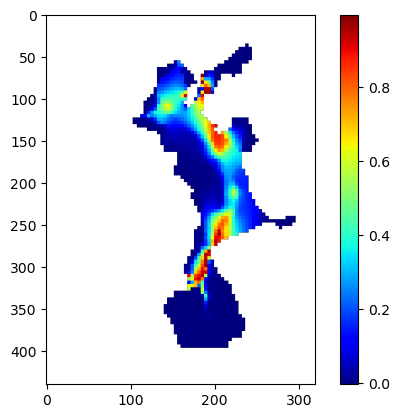

In [7]:
c = plt.imshow(cf2, cmap="jet")
plt.colorbar(c)

In [8]:
wsl = data_path / "uspb" / "flopy"
ml = flopy.modflow.Modflow.load("DG.nam", model_ws=wsl, verbose=False)

In [9]:
nlay, nrow, ncol = ml.nlay, ml.dis.nrow, ml.dis.ncol
xmax, ymax = ncol * 250.0, nrow * 250.0

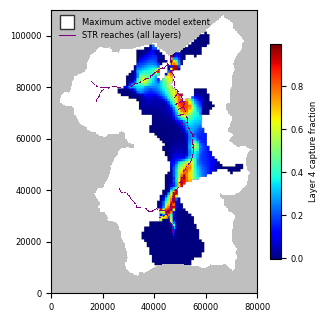

In [10]:
plt.rcParams.update({"font.size": 6})
fig = plt.figure(figsize=(3.25, 4.47))
ax1 = plt.gca()
ax1.set_aspect("equal")
mm1 = flopy.plot.PlotMapView(model=ml, layer=4)
plt.xlim(0, xmax)
plt.ylim(0, ymax)
mm1.plot_inactive(color_noflow="0.75")
c = plt.imshow(cf2, cmap="jet", extent=[0, ncol * 250.0, 0, nrow * 250.0])
cb = plt.colorbar(c, shrink=0.5)
cb.ax.set_ylabel("Layer 4 capture fraction")
mm1.plot_bc(ftype="STR", plotAll=True)
plt.plot(
    [-10000],
    [-10000],
    marker="s",
    ms=10,
    lw=0.0,
    mec="0.2",
    mfc="white",
    label="Maximum active model extent",
)
plt.plot(
    [-10000, 0], [-10000, 0], color="purple", lw=0.75, label="STR reaches (all layers)"
)
leg = plt.legend(loc="upper left", numpoints=1, prop={"size": 6})
leg.draw_frame(False)
plt.xticks([0, 20000, 40000, 60000, 80000])
plt.tight_layout()
plt.savefig(os.path.join(ws, "capture_fraction_010y.png"), dpi=300)

Rerun the model after changing workspace and writing input files

In [11]:
ml.change_model_ws(ws)
ml.exe_name = "mf2005dbl"
ml.write_input()
success, buff = ml.run_model(silent=True)
assert success, pformat(buff)

In [12]:
hedObj = flopy.utils.HeadFile(os.path.join(ws, "DG.hds"), precision="double")
h = hedObj.get_data(kstpkper=(0, 0))
cbcObj = flopy.utils.CellBudgetFile(os.path.join(ws, "DG.cbc"), precision="double")

frf = cbcObj.get_data(kstpkper=(0, 0), text="FLOW RIGHT FACE")[0]
fff = cbcObj.get_data(kstpkper=(0, 0), text="FLOW FRONT FACE")[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge((frf, fff, None), ml)

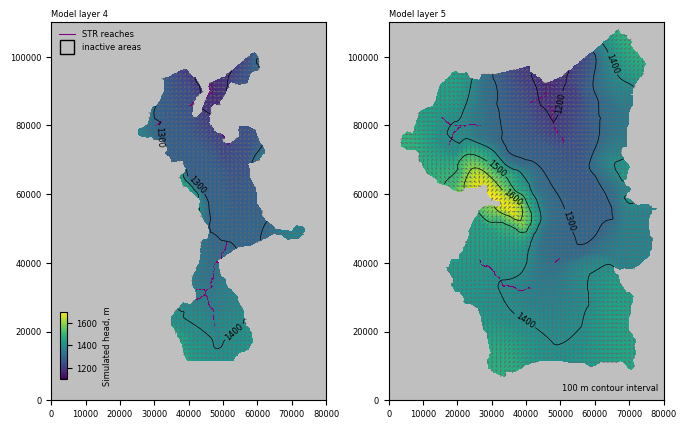

In [13]:
cnt = np.arange(1200, 1700, 100)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.75, 4.47), constrained_layout=True)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax1.set_aspect("equal")
ax2.set_aspect("equal")

mm1 = flopy.plot.PlotMapView(model=ml, ax=ax1, layer=3)
h1 = mm1.plot_array(h, masked_values=[-888, -999], vmin=1100, vmax=1700)
mm1.plot_inactive(color_noflow="0.75")
mm1.plot_bc(ftype="STR")
q1 = mm1.plot_vector(
    qx,
    qy,
    istep=5,
    jstep=5,
    normalize=True,
    color="0.4",
    scale=70,
    headwidth=3,
    headlength=3,
    headaxislength=3,
)
c1 = mm1.contour_array(
    h, masked_values=[-888, -999], colors="black", levels=cnt, linewidths=0.5
)
ax1.clabel(c1, fmt="%.0f", inline_spacing=0.5)

mm2 = flopy.plot.PlotMapView(model=ml, ax=ax2, layer=4)
h2 = mm2.plot_array(h, masked_values=[-888, -999], vmin=1100, vmax=1700)
mm2.plot_inactive(color_noflow="0.75")
mm2.plot_bc(ftype="STR")
q2 = mm2.plot_vector(
    qx,
    qy,
    istep=5,
    jstep=5,
    normalize=True,
    color="0.4",
    scale=70,
    headwidth=3,
    headlength=3,
    headaxislength=3,
)
c2 = mm2.contour_array(
    h, masked_values=[-888, -999], colors="black", levels=cnt, linewidths=0.5
)
ax2.clabel(c2, fmt="%.0f", inline_spacing=0.5)

ax3 = f.add_axes([0.08, 0.125, 0.01, 0.15])
cb = plt.colorbar(h2, cax=ax3)
cb.ax.set_ylabel("Simulated head, m")

ax1.plot([-10000, 0], [-10000, 0], color="purple", lw=0.75, label="STR reaches")
ax1.plot(
    [-10000],
    [-10000],
    marker="s",
    ms=10,
    lw=0.0,
    mec="black",
    mfc="None",
    label="inactive areas",
)
leg = ax1.legend(loc="upper left", numpoints=1, prop={"size": 6})
leg.draw_frame(False)

ax1.text(0.0, 1.01, "Model layer 4", ha="left", va="bottom", transform=ax1.transAxes)
ax2.text(
    0.98,
    0.02,
    "100 m contour interval",
    ha="right",
    va="bottom",
    transform=ax2.transAxes,
)
ax2.text(0.0, 1.01, "Model layer 5", ha="left", va="bottom", transform=ax2.transAxes)

plt.savefig(os.path.join(ws, "uspb_heads.png"), dpi=300)

In [14]:
fname = "USPB_capture_fraction_04_10.dat"
pooch.retrieve(
    url=f"https://github.com/modflowpy/flopy/raw/develop/.docs/groundwater_paper/uspb/results/{fname}",
    fname=fname,
    path=data_path / "uspb" / "results",
    known_hash=None,
)
fn = data_path / "uspb" / "results" / fname
cf = np.loadtxt(fn)
cf2 = scipy.ndimage.zoom(cf, 4, order=0)

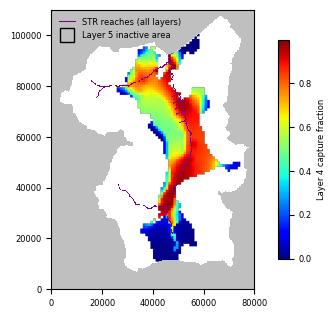

In [15]:
fig = plt.figure(figsize=(3.25, 4.47), constrained_layout=True)
ax1 = plt.gca()
ax1.set_aspect("equal")
mm1 = flopy.plot.PlotMapView(model=ml, layer=4)
plt.xlim(0, xmax)
plt.ylim(0, ymax)
mm1.plot_inactive(color_noflow="0.75")
c = plt.imshow(cf2, cmap="jet", extent=[0, ncol * 250.0, 0, nrow * 250.0])
cb = plt.colorbar(c, shrink=0.5)
cb.ax.set_ylabel("Layer 4 capture fraction")
mm1.plot_bc(ftype="STR", plotAll=True)
plt.plot(
    [-10000, 0],
    [-10000, 0],
    color="purple",
    lw=0.75,
    label="STR reaches (all layers)",
)
plt.plot(
    [-10000],
    [-10000],
    marker="s",
    ms=10,
    lw=0.0,
    mec="black",
    mfc="None",
    label="Layer 5 inactive area",
)
leg = plt.legend(loc="upper left", numpoints=1, prop={"size": 6})
leg.draw_frame(False)
plt.xticks([0, 20000, 40000, 60000, 80000])
plt.savefig(os.path.join(ws, "capture_fraction_100y.png"), dpi=300)